In [70]:
using Plots

In [ ]:
using DSP
using FFTW
using Statistics
using LinearAlgebra
# using Threads

function sinusoidal(a, f, sr, t, theta=0, DC=0)
    delta_i = 1 / sr
    f2pi = f * 2 * π
    nu = [DC + (a * sin(f2pi * i * delta_i + theta)) for i in 0:(t-1)]
    return nu
end

# Optimized zero pad function
function zero_pad!(data_padded, data)
    data_padded[1:length(data)] .= data
    data_padded[length(data)+1:end] .= 0
end

function coh(s_xx, s_yy, s_xy)
    # Compute the numerator: absolute value of the mean of s_xy along the last dimension
    con_num = abs.(mean(s_xy, dims=ndims(s_xy)))

    # Compute the denominator: square root of the product of means of s_xx and s_yy along the last dimension
    con_den = sqrt.(mean(s_xx, dims=ndims(s_xx)) .* mean(s_yy, dims=ndims(s_yy)))

    # Calculate coherence as the element-wise division of numerator by denominator
    coh = con_num ./ con_den
    return coh
end

function get_dpss_and_ratios(n, nw, ntapers; zerophase=false)
    # Compute DPSS windows
    windows = dpss(n, nw, ntapers; zerophase=zerophase)

    # Compute eigenvalues (concentration ratios)
    eigenvalues = dpsseig(windows, nw)

    return windows, eigenvalues
end

function next_fast_len(target::Int)::Int
    """
    Find the next fast size of input data to `fft`, for zero-padding, etc.

    Returns the next composite of the prime factors 2, 3, and 5 which is
    greater than or equal to `target`. (These are also known as 5-smooth
    numbers, regular numbers, or Hamming numbers.)

    Parameters
    ----------
    target : Int
        Length to start searching from. Must be a positive integer.

    Returns
    -------
    out : Int
        The first 5-smooth number greater than or equal to `target`.
    """
    # Precomputed Hamming numbers (5-smooth numbers) for quick lookup
    hams = [
        8, 9, 10, 12, 15, 16, 18, 20, 24, 25, 27, 30, 32, 36, 40, 45, 48, 50,
        54, 60, 64, 72, 75, 80, 81, 90, 96, 100, 108, 120, 125, 128, 135, 144,
        150, 160, 162, 180, 192, 200, 216, 225, 240, 243, 250, 256, 270, 288,
        300, 320, 324, 360, 375, 384, 400, 405, 432, 450, 480, 486, 500, 512,
        540, 576, 600, 625, 640, 648, 675, 720, 729, 750, 768, 800, 810, 864,
        900, 960, 972, 1000, 1024, 1080, 1125, 1152, 1200, 1215, 1250, 1280,
        1296, 1350, 1440, 1458, 1500, 1536, 1600, 1620, 1728, 1800, 1875, 1920,
        1944, 2000, 2025, 2048, 2160, 2187, 2250, 2304, 2400, 2430, 2500, 2560,
        2592, 2700, 2880, 2916, 3000, 3072, 3125, 3200, 3240, 3375, 3456, 3600,
        3645, 3750, 3840, 3888, 4000, 4050, 4096, 4320, 4374, 4500, 4608, 4800,
        4860, 5000, 5120, 5184, 5400, 5625, 5760, 5832, 6000, 6075, 6144, 6250,
        6400, 6480, 6561, 6750, 6912, 7200, 7290, 7500, 7680, 7776, 8000, 8100,
        8192, 8640, 8748, 9000, 9216, 9375, 9600, 9720, 10000
    ]

    if target <= 6
        return target
    end

    # Check if target is already a power of 2
    if (target & (target - 1)) == 0
        return target
    end

    # Quick lookup for small sizes
    if target <= hams[end]
        idx = searchsortedfirst(hams, target)
        return hams[idx]
    end

    # Function to compute the bit length of an integer
    bit_length(x::Int) = x <= 0 ? 0 : floor(Int, log2(x)) + 1

    match = typemax(Int)  # Initialize with maximum possible integer
    p5 = 1
    while p5 < target
        p35 = p5
        while p35 < target
            # Ceiling integer division
            quotient = cld(target, p35)
            p2 = 2^bit_length(quotient - 1)
            N = p2 * p35
            if N == target
                return N
            elseif N < match
                match = N
            end
            p35 *= 3
            if p35 == target
                return p35
            end
        end
        if p35 < match
            match = p35
        end
        p5 *= 5
        if p5 == target
            return p5
        end
    end
    if p5 < match
        match = p5
    end
    return match
end

function _get_nfft(Ws, X)::Int
    max_len = maximum([length(Wk) for Wk in Ws])
    n = last(size(X))
    nfft = n + max_len - 1
    # @show nfft
    nfft = next_fast_len(nfft)
    return nfft
end

# Precompute FFTs of Ws
function precompute_fft_Ws(Ws, nfft)
    n_taps, n_freqs = size(Ws)
    fft_Ws = Array{ComplexF64, 3}(undef, n_taps, n_freqs, nfft)
    for taper_idx = 1:n_taps
        for freq_idx = 1:n_freqs
            W = Ws[taper_idx, freq_idx]
            padded_W = zeros(ComplexF64, nfft)
            zero_pad!(padded_W, W)
            fft_Ws[taper_idx, freq_idx, :] = fft(padded_W)
        end
    end
    return fft_Ws
end

# Precompute FFTs of X
function precompute_fft_X(X, nfft)
    n_epochs, n_channels, n_times = size(X)
    fft_X = Array{ComplexF64, 3}(undef, n_epochs, n_channels, nfft)
    for epoch_idx = 1:n_epochs
        for channel_idx = 1:n_channels
            x = X[epoch_idx, channel_idx, :]
            padded_x = zeros(ComplexF64, nfft)
            zero_pad!(padded_x, x)
            fft_X[epoch_idx, channel_idx, :] = fft(padded_x)
        end
    end
    return fft_X
end


# Main function to compute tfr
function compute_tfr(X, Ws, nfft)
    n_epochs, n_channels, n_times = size(X)
    n_taps, n_freqs = size(Ws)
    tfr = zeros(ComplexF64, n_epochs, n_channels, n_taps, n_freqs, n_times)
    
    # Precompute FFTs
    fft_Ws = precompute_fft_Ws(Ws, nfft)
    fft_X = precompute_fft_X(X, nfft)
    
    # Loop over tapers and frequencies
    for taper_idx = 1:n_taps
        for freq_idx = 1:n_freqs
            fft_W = fft_Ws[taper_idx, freq_idx, :]
            W_size = length(Ws[taper_idx, freq_idx])
            total_size = n_times + W_size - 1
            ret_size = total_size
            # Preallocate ret array
            ret = zeros(ComplexF64, ret_size)
            
            for epoch_idx = 1:n_epochs
                for channel_idx = 1:n_channels
                    fx = fft_X[epoch_idx, channel_idx, :]
                    product = fx .* fft_W
                    ret .= ifft(product)[1:ret_size]
                    
                    # Center the result
                    start = Int(floor((ret_size - n_times) / 2)) + 1
                    end_time = start + n_times - 1
                    tfr[epoch_idx, channel_idx, taper_idx, freq_idx, :] = ret[start:end_time]
                end
            end
        end
    end
    return tfr, fft_Ws, fft_X
end

compute_tfr (generic function with 1 method)

In [ ]:
t = 32
sr = 32
f = 2
noise = 1000

v = sinusoidal(10, f, sr, t * 4, 0)
w = sinusoidal(10, f, sr, t * 4, π / 4)
y = sinusoidal(10, f, sr, t * 4, π / 2)
z = sinusoidal(10, f, sr, t * 4, π)


# data = [[v w y z], [-v -w -y -z]];
data = Array{Float64}(undef, 2, 4, 128)
data[1, :, :] = hcat(v, w, y, z)'
data[2, :, :] = hcat(-v, -w, -y, -z)'

freqs = collect(2:15) # inclusive of end 
n_freqs = length(freqs)
mt_bandwidth = 4
n_taps = floor(Int, mt_bandwidth - 1)
n_cycles = 7
sfreq = 32
zero_mean = true
# random data epochs x channels x time
X = data;

# Preallocate Ws as a matrix
Ws = Matrix{Vector{ComplexF64}}(undef, n_taps, n_freqs)
sp5 = sqrt(0.5)
# Loop over frequencies first
for k = 1:n_freqs
    f = freqs[k]
    t_win = n_cycles / f
    len_t = Int(ceil(t_win * sfreq))

    t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0)) # Ensure t_win is excluded
    t_centered = t .- t_win / 2.0

    # Precompute oscillation and taper
    oscillation = exp.(2.0 * im * pi * f .* t_centered)
    taper = dpss(len_t, mt_bandwidth / 2, n_taps)

    for m = 1:n_taps
        # Use @view to avoid copying taper column
        Wk = oscillation .* @view taper[:, m]
        if zero_mean  # To make it zero mean
            real_offset = mean(Wk)
            Wk .-= real_offset
        end
        # Normalize Wk
        Wk /= sp5 * norm(Wk)
        # Store Wk in preallocated Ws
        Ws[m, k] = Wk
    end
end


In [18]:
n_epochs, n_channels, n_times = size(X)
n_taps, n_freqs = size(Ws)


(3, 14)

In [24]:


# this loops over all the channels and gives a (1, 4, 3, 14, 128) matrix in python. where 1 is epochs, 4 is channels, 3 is multitapers, 14 is freqs, 128 is time

# _cwt_gen function in python equivalent
n_times = size(X, ndims(X))
nfft = _get_nfft(Ws, X) # only needs to be done once i think
tfr, fft_Ws, fft_X = compute_tfr(X, Ws, nfft);

weights = zeros(n_taps, length(freqs), size(tfr, ndims(tfr)));
for (i, f) in enumerate(freqs)
    # Create the window length array as in np.arange
    window_length = length(0.0:1.0/sfreq:(n_cycles/f))

    # Calculate half bandwidth and number of tapers
    half_nbw = mt_bandwidth / 2.0
    n_tapers = floor(Int, mt_bandwidth - 1)

    # Generate DPSS windows with the given parameters
    w, e = get_dpss_and_ratios(window_length, half_nbw, n_tapers; zerophase=false)

    # Assign the square root of eigvals to the weights array
    weights[:, i, :] .= sqrt.(e)
end

In [26]:
size(tfr)

(2, 4, 3, 14, 128)

in python its 

psd = weights * w 

weights.shape = (3, 14, 128)

w.shape = (4,3,14,128) and is the same as tfr

In [47]:

epoch_idx = 1
expanded_weights = reshape(weights, (1, size(weights, 1), size(weights, 2), size(weights, 3)));

psd_per_epoch = zeros(size(X,1), size(X, 2), size(weights, 2), size(X, 3));


In [49]:
for epoch_idx = 1:size(X,1)
# Perform the element-wise multiplication with broadcasting
psd = expanded_weights .* tfr[epoch_idx, :, :, :, :]

# Square magnitude (complex conjugate multiplication)
psd = psd .* conj(psd)

# Sum across the second dimension (axis=1 in Python)
psd = sum(real(psd), dims=2)

# Calculate normalization factor for `weights`, matching dimensions
normalization = 2 ./ sum(real(expanded_weights .* conj(expanded_weights)), dims=2)
psd = psd .* normalization

psd_squeezed = dropdims(psd, dims=2);

psd_per_epoch[epoch_idx, :, :, :] .= psd_squeezed
end

In [50]:
size(psd_per_epoch)

(2, 4, 14, 128)

In [51]:
epoch_idx = 1
w_x = tfr[epoch_idx, x, :, :, :]
w_y = tfr[epoch_idx, y, :, :, :]
s_xy = sum(weights .* w_x .* conj(weights .* w_y), dims=1)  # sum over tapers
normalization = 2 ./ sum(real(weights .* conj(weights)), dims=1)
s_xy = s_xy .* normalization

s_xy_squeezed = dropdims(s_xy, dims=1)

s_xx = psd_squeezed[x, :, :]
s_yy = psd_squeezed[y, :, :];

coherence = coh(s_xx, s_yy, s_xy_squeezed)

14×1 Matrix{Float64}:
 0.9994252084251058
 0.98346660940613
 0.9080166469686225
 0.857023619580531
 0.7068454762196555
 0.5717890713144725
 0.8071777638510679
 0.7498216766829018
 0.5687639595078359
 0.3537812098669173
 0.4749134039255745
 0.5187591821735892
 0.5952759172804776
 0.6143511365704714

In [57]:
coherence = zeros(size(X, 1), size(X, 2), size(X, 2), size(psd_per_epoch, 3))

for epoch_idx = 1:size(X, 1)
    for x = 1:size(X, 2)
        for y = 1:size(X, 2)
            w_x = tfr[epoch_idx, x, :, :, :]
            w_y = tfr[epoch_idx, y, :, :, :]
            s_xy = sum(weights .* w_x .* conj(weights .* w_y), dims=1)  # sum over tapers
            normalization = 2 ./ sum(real(weights .* conj(weights)), dims=1)
            s_xy = s_xy .* normalization

            s_xy_squeezed = dropdims(s_xy, dims=1)

            s_xx = psd_squeezed[x, :, :]
            s_yy = psd_squeezed[y, :, :];

            coherence[epoch_idx,x, y, :] .= coh(s_xx, s_yy, s_xy_squeezed)

        end
    end
end


In [60]:
using NPZ

# Load the .npy file
python_coh = npzread("/media/dan/Data/git/network_miner/coh_python.npy");

In [64]:
size(coherence), size(python_coh)

((2, 4, 4, 14), (2, 4, 4, 14))

In [65]:
coherence[1,1,4,:] == coherence[1,4,1,:]

true

In [66]:
coherence == python_coh

false

In [62]:
isapprox(coherence, python_coh; atol=1e-13)

false

In [67]:
isapprox(coherence[1,1,1,:], python_coh[1,1,1,:]; atol=1e-13)

false

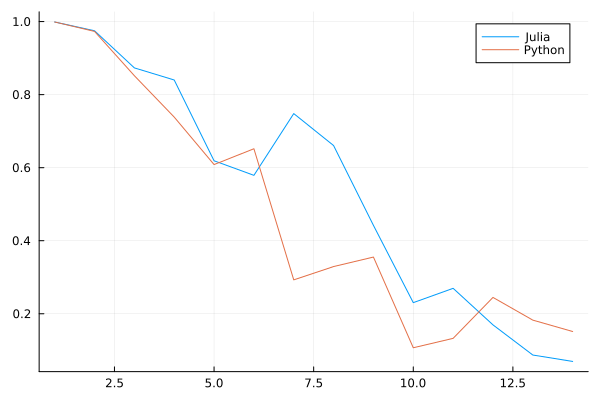

In [90]:
i = 3
plot(coherence[2, i, 1, :], label="Julia")
plot!(python_coh[2, i, 1, :], label="Python")